In [44]:
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import discretization_mod as dm
import os
import xml.etree.ElementTree as ET

import random
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import scipy as sp
from scipy import special
from scipy import stats
import xlwt

from scipy.optimize import minimize
from scipy import integrate


def f(x, func, kde, X, x_min, x_max):
    y, px, cov, p = func(x, kde, X, x_min, x_max)
    return cov

def grad(x, func, kde, X, x_min, x_max, alpha=10):
    y, px, cov, p = func(x, kde, X, x_min, x_max)
    step = alpha * px  * (y[1:] - y[:-1]) * (y[1:] + y[:-1] - 2 * x) / 2
    return step

def cov_kde(x0, kde, X, x_min, x_max):
    p = np.zeros(len(x0) + 1)
    C = np.zeros(len(x0) + 1) 
    y = np.zeros(len(x0) + 1) 
    x_ext = sorted(np.append(x0, [x_min, x_max]))
    for i in range(len(x_ext)-1):
        mask = np.logical_and(x_ext[i] < X, X <= x_ext[i + 1])
        p[i] = len(X[mask]) 
        C[i] = np.sum(X[mask]) 
        if p[i] == 0: 
            C[i] = 0
            p[i] = 1
    y = C / p
    px = kde.evaluate(x0)
    cov = np.linalg.norm(C / np.sqrt(p)) #/ sigma_kde
    return y, px, cov, p

def exponential_discretisation(X, bits):
    std_W = np.std(X)
    max_W = np.fabs(X).max()
    x0 = (std_W / max_W) * 0.5**(bits-1)
    signs = np.sign(X)
    q_a = np.fabs(X.flatten()) / max_W
    n = 2 ** (bits - 1)
    q = 1 / x0 ** (1 / (n - 1))
    assert (x0 < 1)
    xx = [0] + [x0 * q ** i for i in range(n)]
    q_mean = np.zeros(q_a.size, dtype=np.float) + np.mean(q_a[q_a > xx[n - 1]])
    for i in range(len(xx) - 2):
        ii = np.logical_and(xx[i] < q_a, q_a <= xx[i + 1])
        q_mean[ii] = np.mean(q_a[ii])
    new_W = np.reshape(q_mean, X.shape) * signs * max_W
    return new_W, np.corrcoef(np.ravel(X), np.ravel(new_W))[1,0], np.array(xx) * max_W

def linear_discretization_ceil_nonzero(X, bitwidth):
    std_W = np.std(X)
    max_W = np.fabs(X).max()
    x0 = (std_W / max_W) * 0.5**(bitwidth-1)
    M = np.fabs(X).max()
    signs = np.sign(X)
    assert(x0 < 1)
    n = 2 ** (bitwidth - 1)# the number of gradation
    q = (1 - x0) / (n - 1)
    q_weights = np.fabs(X.flatten()) / M # between 0 and 1
    q_weights[abs(q_weights - 1.0) < 1e-7] = 1.0 - 1e-7 # remove maximal
    q_int = np.zeros(q_weights.size, dtype=np.int)
    q_int[q_weights <= x0] = 0
    q_int[q_weights > x0] = np.ceil((q_weights[q_weights > x0] - x0) / q)  # integers  
    x = x0 + q * q_int
    x = np.array(x, dtype=np.float16)
    xx = [0] + [x0 + q * i for i in range(n)]
    new_W = np.reshape(x, X.shape) * signs * M
    return new_W, np.corrcoef(np.ravel(X), np.ravel(new_W))[1,0], np.array(xx) * max_W

def results(kde, w, x0, x_min, x_max, func, bits, alpha=1, tol_curr=1e-4, ans_case='CG'):
    
    n_d = 2 ** bits
    
    fx = lambda x: -f(x, func, kde, w, x_min, x_max)
    gradx = lambda x: -grad(x, func, kde, w, x_min, x_max, alpha)
    
    ans = minimize(fun=fx, x0=x0, jac=gradx, method='CG', tol=tol_curr)#, options={'gtol': 1e-1})
    solutions = ans['x']
    correlations = -ans['fun'] #/ np.std(X_small)
    gradients = np.linalg.norm(gradx(ans['x'])) / alpha / n_d
    return solutions, correlations, gradients

In [46]:
def save_corrs_to_xls(name, results, len_layers, grad_bit, init_discr, alpha=1):
    
    book = xlwt.Workbook(encoding="utf-8")
    sheet1 = book.add_sheet(str(grad_bit) + str(init_discr)) 
    sheet1.write(0, 0, 'layer')
    sheet1.write(0, 1, 'before opt')
    sheet1.write(0, 2, 'after opt')
    for j in range(len_layers):
        sheet1.write(j + 1, 0, results[j, 0])
        sheet1.write(j + 1, 1, results[j, 1])
        sheet1.write(j + 1, 2, results[j, 2])
    book.save('Xception' + name + str(grad_bit) + str(init_discr) + '.xls')

In [27]:
def save_tops_to_xls(name, top1, top5, grad_bit, init_discr='1', alpha=1):
    
    book = xlwt.Workbook(encoding="utf-8")
    sheet1 = book.add_sheet(init_discr) 
    sheet1.write(0, 0, 'grad_bit')
    sheet1.write(0, 1, 'top1')
    sheet1.write(0, 2, 'top5') 
    sheet1.write(grad_bit-2, 0, grad_bit)
    sheet1.write(grad_bit-2, 1, top1)
    sheet1.write(grad_bit-2, 2, top5)
    book.save(name + 'tops' + str(grad_bit) + str(init_discr) + '.xls')

In [47]:
def load_batch_of_images(batch_size = 100, images_folder='imagenet/preprocessed images val', xml_folder='imagenet/xml val'):  
    jpeg_files = [file for file in os.listdir(images_folder)]
    random.shuffle(jpeg_files)
    jpeg_files_batch = jpeg_files[:batch_size]
    batch = []
    for i in range(batch_size):
        img = image.load_img(os.path.join('.', images_folder, jpeg_files_batch[i]), target_size=(299, 299))
        img = image.img_to_array(img)
        batch.append(img)

    batch = np.asarray(batch)
    #x = np.expand_dims(batch, axis=0)
    batch = preprocess_input(batch)
    xml_files = [file.split('.')[0] + '.xml' for file in jpeg_files_batch]
    answers = []
    for i in range(batch_size):
        tree = ET.parse(os.path.join(xml_folder, xml_files[i]))
        root = tree.getroot()
        valid_value = root[5][0].text
        answers.append(valid_value)
    
    return batch, answers

def compute_accuracy_on_batch_of_images(batch, model, answers):  
    preds = model.predict(batch)
    # convert the probabilities to class labels
    labels = decode_predictions(preds)
    top1_correct = 0
    top5_correct = 0
    for i in range(len(batch)):
        if answers[i] == labels[i][0][0]:
            top1_correct += 1
        for k in range(5):
            if answers[i] in labels[i][k][0]:
                top5_correct += 1
                break
    top1_correct /= len(batch)
    top5_correct /= len(batch)
    #print("Top1:", top1_correct)
    #print("Top5:", top5_correct)
    
    return top1_correct, top5_correct

In [34]:
def change_all_weights(weights, grad_bit, layers_to_quant, 
                       init_discr='linear', type_of_change='best', alpha=1):
    quant_weights = weights.copy()
    layer_correlations = np.zeros((len(layers_to_quant), 3))
    row = 0
    for layer in layers_to_quant:
        layer_correlations[row, 0] = layer
        w_rav = np.ravel(quant_weights[layer])
        w_norm = (w_rav - np.mean(w_rav)) / np.std(w_rav)
        if len(w_norm) > 10000:
            w_small = np.random.choice(w_norm, 10000, replace=False)
        else: w_small = w_norm
        kde = stats.gaussian_kde(w_small, bw_method='scott')
        
        if init_discr == 'linear':
            weights_layer, corr, xx = linear_discretization_ceil_nonzero(w_norm, grad_bit)
        else:
            weights_layer, corr, xx = exponential_discretisation(w_norm, grad_bit)
            
        x0 = np.sort(np.append(xx, -xx[1:]))
        #print('layer = ', layer)
        #print('exp corr = ', corr )
        layer_correlations[row, 1] = corr
        w_min = x0.min()
        w_max = x0.max()
        solutions, correlations, gradients = results(kde, w_norm, x0[1:-1],
                                                w_min, w_max, cov_kde, grad_bit, alpha=alpha, ans_case='CG')
        quant = np.sort(np.append(solutions, [w_max, w_min])) 
        w_discr = w_rav.copy()
        x_discr = cov_kde(solutions, kde, w_norm, w_min, w_max)[0]
        for i in range(len(quant) - 1):
            mask = np.logical_and(quant[i] <= w_norm, quant[i+1] >= w_norm)
            w_discr[mask] = x_discr[i] * np.std(w_rav) + np.mean(w_rav)
        
        layer_correlations[row, 2] = np.corrcoef(w_rav, w_discr)[1,0]
        
        if type_of_change =='best' and np.corrcoef(w_rav, w_discr)[1,0] < corr:
            quant_weights[layer] = weights_layer.reshape(quant_weights[layer].shape) *\
                                        np.std(w_rav) + np.mean(w_rav)
        else:
            quant_weights[layer] = w_discr.reshape(quant_weights[layer].shape)
            
        row += 1
    save_corrs_to_xls(type_of_change, layer_correlations, len(layers_to_quant), grad_bit, init_discr, alpha)
    return quant_weights

In [48]:
batch, true_answers = load_batch_of_images(batch_size=100)

## Xception

In [36]:
 m  

C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  ou

C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  ou

C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  ou

In [49]:
model = Xception(weights='imagenet')
weights = np.array(model.get_weights())
top1, top5 = compute_accuracy_on_batch_of_images(batch, model, true_answers)

In [50]:
top1, top5

(0.75, 0.92)

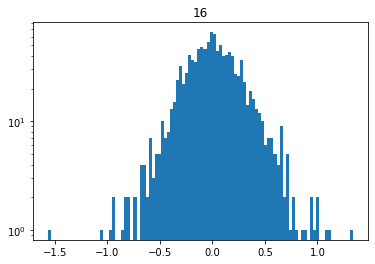

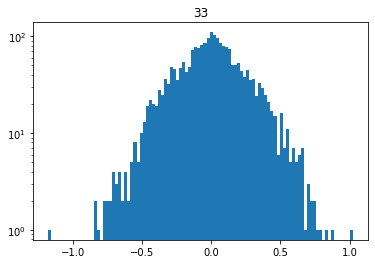

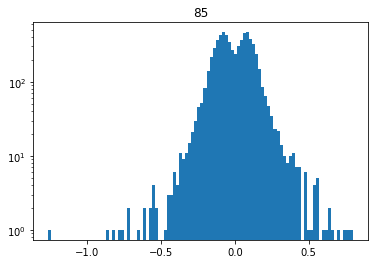

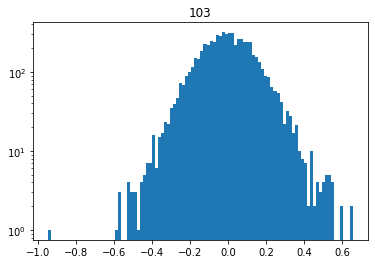

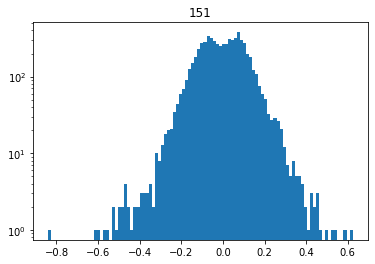

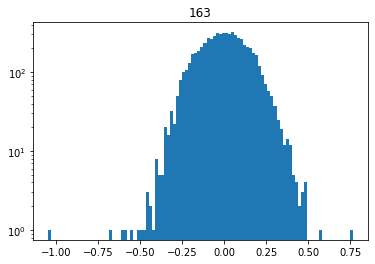

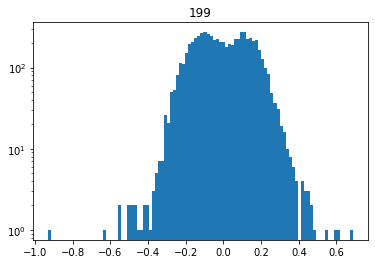

In [54]:
for i in [16, 33, 85, 103, 151, 163, 199]:
    plt.title(i)
    plt.hist(weights[i].flatten(), bins=100)
    plt.yscale('log')
    plt.show()

In [53]:
for i in [16, 33, 85, 103, 151, 163, 199]:
    print('layer i size ', weights[i].shape)

layer i size  (3, 3, 128, 1)
layer i size  (3, 3, 256, 1)
layer i size  (3, 3, 728, 1)
layer i size  (3, 3, 728, 1)
layer i size  (3, 3, 728, 1)
layer i size  (3, 3, 728, 1)
layer i size  (3, 3, 728, 1)
